In [1]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv
from numpy import array, random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from joblib import Parallel, delayed

In [2]:
directory = r"C:\Users\omgit\Downloads\GROUP ASSIGNMENT DSC use-case-20241205\GROUP ASSIGNMENT DSC use-case-20241205"


In [3]:
random.seed(12)

In [4]:
training_data =pd.read_csv(directory + "\\train_final.csv")

In [5]:
validation_data =pd.read_csv(directory + "\\validation_final.csv")

In [6]:
training_data.dtypes

Unnamed: 0                       int64
donorID                         object
zipcode                          int64
gender_missing                   int64
lang_FR                          int64
                                ...   
donation_value_bins_150-159    float64
donation_value_bins_160-169    float64
donation_value_bins_170-179    float64
donation_value_bins_180+       float64
active_in_last_five_years        int64
Length: 75, dtype: object

In [7]:
training_data[["donorID",'campaign6169success']].groupby(['campaign6169success']).count()

,donorID
campaign6169success,
0,33923
1,950


In [8]:
validation_data[["donorID",'campaign7244success']].groupby(['campaign7244success']).count()

,donorID
campaign7244success,
0,25427
1,217


In [9]:
training_data= training_data.rename(columns={'campaign6169success':'campaign_success'})
validation_data= validation_data.rename(columns={'campaign7244success':'campaign_success'})

Most relevant features: Index(['lang_FR', 'lang_NL', 'reg_Flanders', 'reg_Wallonia', 'age_group_30-39',
       'age_group_50-59', 'age_group_60-69', 'age_group_70-79',
       'age_group_80-89', 'province_Liege', 'province_Luxembourg',
       'province_Missing', 'days_bins_24-27 months', 'days_bins_36-39 months',
       'days_bins_51-54 months', 'donation_value_bins_0-9',
       'donation_value_bins_20-29', 'donation_value_bins_40-49',
       'donation_value_bins_80-89', 'donation_value_bins_90-99',
       'donation_value_bins_130-139'],
      dtype='object')


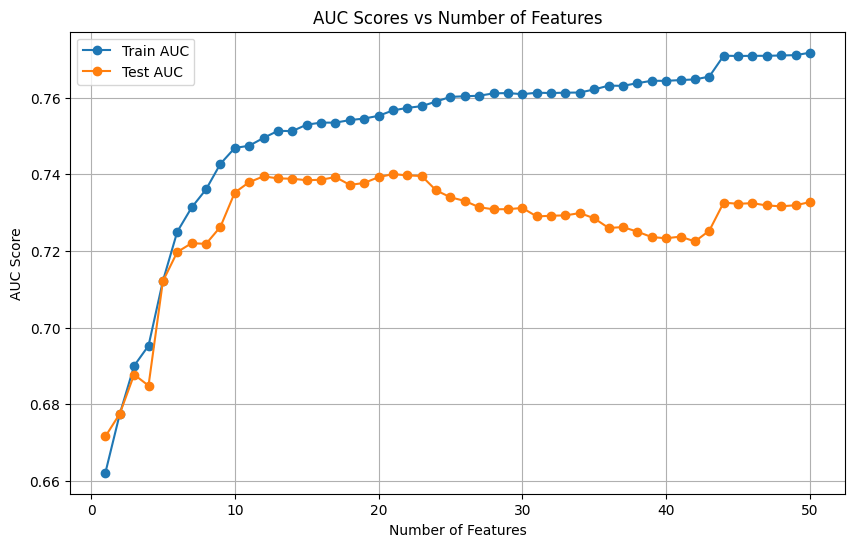

In [10]:
X = training_data.drop(columns=['campaign_success', 'donorID'])  # Drop target and ID columns
y = training_data['campaign_success']

# Train-test split for validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_train_filtered = constant_filter.fit_transform(X_train_scaled)
X_test_filtered = constant_filter.transform(X_test_scaled)

# Limit the maximum number of features to test
max_features = min(X_train_filtered.shape[1], 50)  # Use up to 50 features

# Function to compute AUC for a given number of features
def compute_auc(k):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = selector.fit_transform(X_train_filtered, y_train)
    X_test_kbest = selector.transform(X_test_filtered)
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    model.fit(X_train_kbest, y_train)
    y_train_prob = model.predict_proba(X_train_kbest)[:, 1]
    y_test_prob = model.predict_proba(X_test_kbest)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    return train_auc, test_auc, k, selector.get_support(indices=True)

# Parallelize the computation for efficiency
results = Parallel(n_jobs=-1)(delayed(compute_auc)(k) for k in range(1, max_features + 1))

# Collect results for plotting
feature_counts = [r[2] for r in results]
train_aucs = [r[0] for r in results]
test_aucs = [r[1] for r in results]

# Find the best result by test AUC
best_result = max(results, key=lambda x: x[1])
selected_feature_indices = best_result[3]
selected_feature_names = X_train.columns[selected_feature_indices]

# Print the most relevant features
print("Most relevant features:", selected_feature_names)

# Plot AUC scores vs number of features
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, train_aucs, label='Train AUC', marker='o')
plt.plot(feature_counts, test_aucs, label='Test AUC', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.title('AUC Scores vs Number of Features')
plt.legend()
plt.grid()
plt.show()

Validation AUC with 21 features: 0.6467184724536257
Accuracy: 0.6629231009202933
Precision: 0.013284047591544414
Recall: 0.5299539170506913
F1 Score: 0.025918413342348432


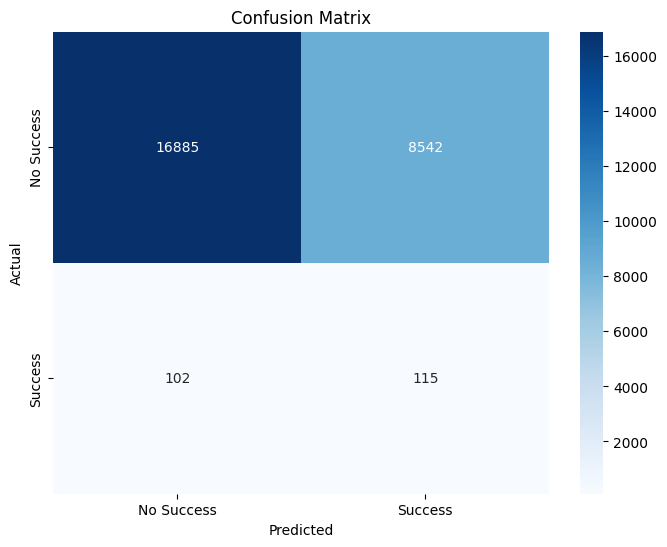

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.66      0.80     25427
           1       0.01      0.53      0.03       217

    accuracy                           0.66     25644
   macro avg       0.50      0.60      0.41     25644
weighted avg       0.99      0.66      0.79     25644



In [11]:
X_validation = validation_data.drop(columns=['campaign_success', 'donorID'])
y_validation = validation_data['campaign_success']

# Standardize validation data
X_validation_scaled = scaler.transform(X_validation)

# Align validation data to the training data columns after constant filtering
X_validation_filtered = constant_filter.transform(X_validation_scaled)

# Apply the same SelectKBest transformation used in training
selector = SelectKBest(score_func=f_classif, k=best_result[2])
X_train_kbest = selector.fit_transform(X_train_filtered, y_train)  # Fit on training data
X_validation_kbest = selector.transform(X_validation_filtered)

# Train the model on the selected features of the training dataset
validation_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

validation_model.fit(X_train_kbest, y_train)

# Predict probabilities on the validation dataset
y_validation_prob = validation_model.predict_proba(X_validation_kbest)[:, 1]
y_validation_pred = validation_model.predict(X_validation_kbest)

# Calculate the AUC for the validation dataset
validation_auc = roc_auc_score(y_validation, y_validation_prob)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)
conf_matrix = confusion_matrix(y_validation, y_validation_pred)

print(f"Validation AUC with {best_result[2]} features: {validation_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Success', 'Success'], yticklabels=['No Success', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_validation, y_validation_pred))


C:\Users\omgit\AppData\Local\Temp\ipykernel_4812\1156067497.py:10: RuntimeWarning: invalid value encountered in divide
  lift = cumulative_gains / baseline


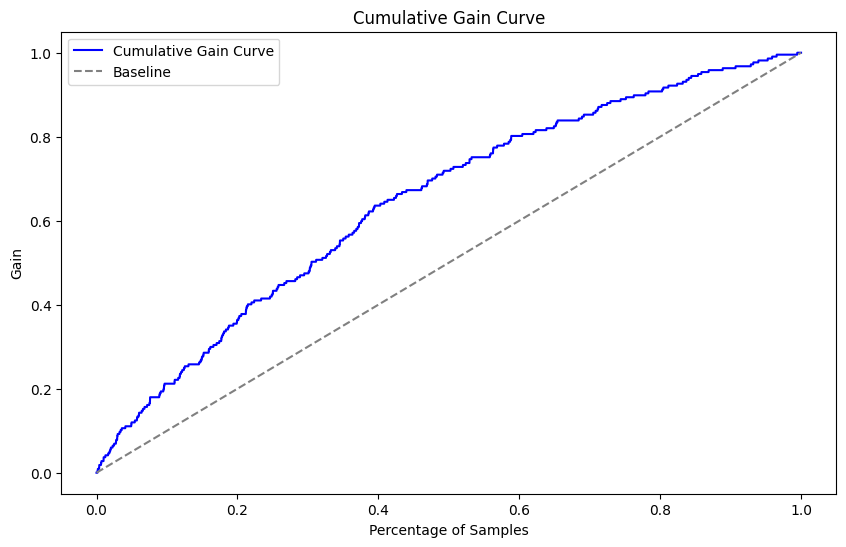

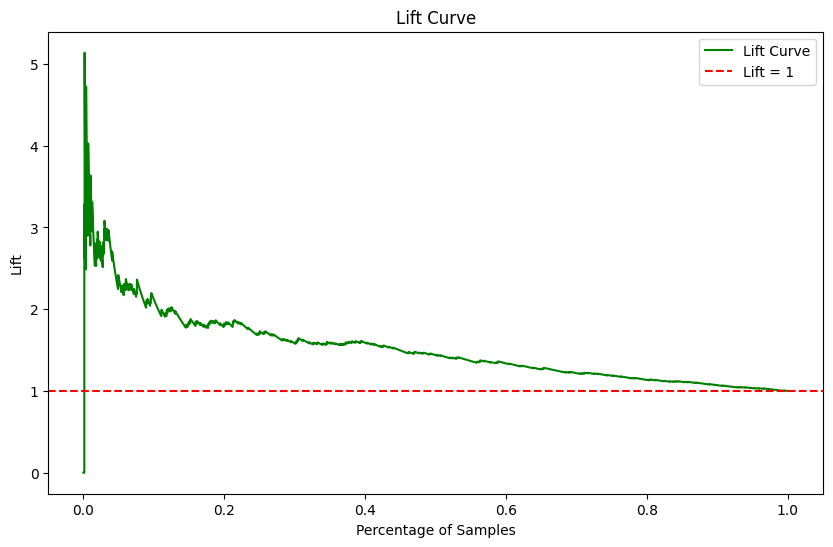

In [12]:
def plot_lift_and_gain(y_true, y_probs):
    # Sort probabilities and true labels by predicted probability
    sorted_indices = np.argsort(y_probs)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]
    y_probs_sorted = np.array(y_probs)[sorted_indices]

    # Compute cumulative gain and lift
    cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    baseline = np.linspace(0, 1, len(y_true_sorted))
    lift = cumulative_gains / baseline

    # Plot Cumulative Gain Curve
    plt.figure(figsize=(10, 6))
    plt.plot(baseline, cumulative_gains, label='Cumulative Gain Curve', color='blue')
    plt.plot(baseline, baseline, label='Baseline', linestyle='--', color='gray')
    plt.title('Cumulative Gain Curve')
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Gain')
    plt.legend()
    plt.show()

    # Plot Lift Curve
    plt.figure(figsize=(10, 6))
    plt.plot(baseline, lift, label='Lift Curve', color='green')
    plt.axhline(y=1, color='red', linestyle='--', label='Lift = 1')
    plt.title('Lift Curve')
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Lift')
    plt.legend()
    plt.show()

# Plot lift and gain curves for validation data
plot_lift_and_gain(y_validation, y_validation_prob)

# Scoring

In [13]:
new_donor_data = pd.read_csv(r'C:\Users\omgit\Downloads\GROUP ASSIGNMENT DSC use-case-20241205\GROUP ASSIGNMENT DSC use-case-20241205\scoring_final.csv')  
new_donor_ids = new_donor_data['donorID']  # Keep donor IDs for reference

# Drop donorID and preprocess the data
X_new = new_donor_data.drop(columns=['donorID'])

# Standardize the new data
X_new_scaled = scaler.transform(X_new)

# Apply constant feature filter
X_new_filtered = constant_filter.transform(X_new_scaled)

# Apply the same SelectKBest transformation as training
X_new_kbest = selector.transform(X_new_filtered)

# Predict probabilities using the trained model
new_donor_probs = validation_model.predict_proba(X_new_kbest)[:, 1]

# Prepare the output dataframe
output = pd.DataFrame({
    'donorID': new_donor_ids,
    'predicted': new_donor_probs
})

# Save the predictions to a CSV file
output.to_csv(r'C:\Users\omgit\Downloads\GROUP ASSIGNMENT DSC use-case-20241205\GROUP ASSIGNMENT DSC use-case-20241205\scoring_submission.csv', index=False)  # Replace with your desired path

# Display the first few predictions
print(output.head())

   donorID  predicted
0  D134242   0.251526
1  D126503   0.358494
2  D104392   0.431685
3  D105905   0.493724
4  D120506   0.209777


Feature Importance (Logistic Regression):
                        Feature  Coefficient  Abs_Coefficient
10                  gender_flag    -0.695847         0.695847
7               age_group_80-89     0.242656         0.242656
6               age_group_70-79     0.224366         0.224366
3               age_group_30-39    -0.197499         0.197499
15    donation_value_bins_50-59     0.192864         0.192864
8               age_group_90-99     0.192613         0.192613
11              no_of_donations    -0.168306         0.168306
20     donation_value_bins_180+     0.160747         0.160747
9      province_Walloon Brabant    -0.154714         0.154714
5               age_group_60-69     0.152946         0.152946
14    donation_value_bins_10-19     0.147430         0.147430
17    donation_value_bins_90-99     0.144787         0.144787
18  donation_value_bins_130-139     0.119679         0.119679
4               age_group_40-49    -0.100592         0.100592
16    donation_value_bins_70

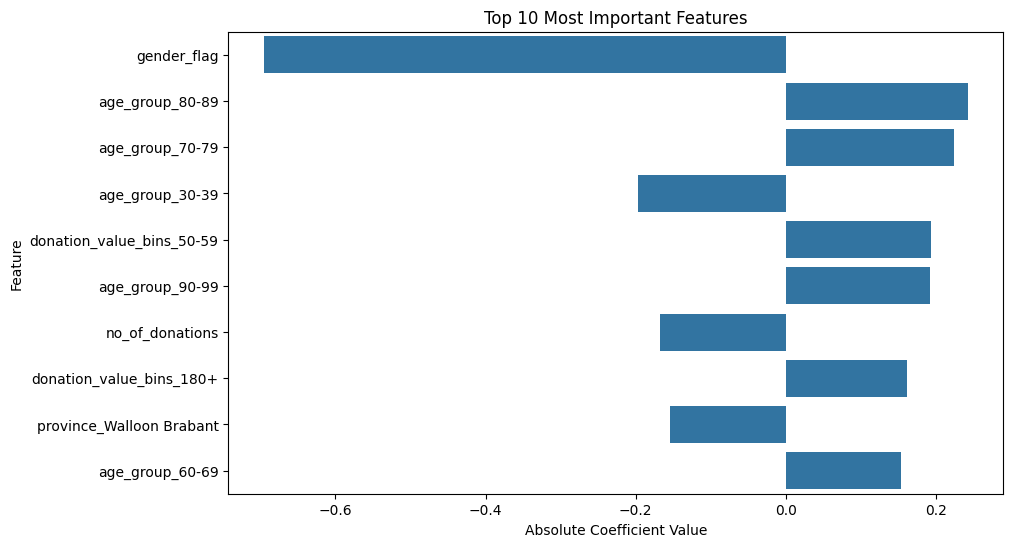

In [14]:
# --- Feature importance based on coefficients ---
# Get the feature names after SelectKBest transformation

filtered_columns = X.columns[constant_filter.get_support()]

final_feature_names = filtered_columns[selector.get_support()]


coefficients = validation_model.coef_[0]  # Coefficients from Logistic Regression

# Combine feature names with their coefficients
feature_importance = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute importance
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print and plot the feature importance
print("Feature Importance (Logistic Regression):")
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()